In [1]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

### Некоторые методы предобработки данных

- Визуализация
- Удаление и корректировка выбросов
- Обработка пропущенных значений
- Обработка категориальных признаков
- Нормализация данных
- Отбор признаков (feature selection)
   - Выявление коррелированных признаков
- Конструирование признаков (feature engineering)

# Оценка стоимости квартиры

Предположим, что вы хотите продать квартиру и желаете узнать, по какой цене следует продавать, чтобы не продешевить.
Загрузим данные о ценах на нижегородские квартиры (данные в 2017 г. собрал Александр Коротких, за что ему выражаю огромную благодарность):

## 1. Загружаем данные

In [2]:
url = "https://raw.githubusercontent.com/NikolaiZolotykh/MachineLearningCourse/master/flats.csv"
data_raw = pd.read_csv(url)

Таблица содержит данные о более 72 тысяч квартир, выставленных на продажу в г.Нижнем Новгороде. Для каждой квартиры указаны ее цена (в тыс. руб.), географические координаты, тип продажи (вторичка или новостройка), количество этажей, тип дома, количество комнат (0 - квартира-студия), номер этажа и общая площадь квартиры (в кв.м).

Вначале посмотрим на размеры таблицы - количество строк (каждая строка соответствует одной квартире) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [3]:
data_raw.shape

(72379, 10)


Метод `data_raw.head()` отображает первые строки (по умолчанию, 5 строк) таблицы

In [4]:
data_raw.head()

,Price,Date,Lat,Lng,Type,Floors,Building,Rooms,Floor,Area
0,3500.0,240,56.365696,43.820250,Resale,9.0,Brick,3.0,4.0,60.0
1,4000.0,240,56.323057,44.007862,Resale,3.0,Brick,3.0,3.0,57.0
2,2150.0,240,56.267552,43.892107,Resale,5.0,Panel,2.0,1.0,38.0
3,3100.0,240,56.359963,43.813756,Resale,5.0,Panel,4.0,2.0,59.0
4,3585.0,240,56.325374,43.937463,Resale,9.0,Panel,2.0,7.0,52.5


А вот последние строки:

In [5]:
data_raw.tail()

,Price,Date,Lat,Lng,Type,Floors,Building,Rooms,Floor,Area
72374,3250.000,372,56.282006,44.085056,Resale,14.0,Monolithic,1.0,1.0,44.7
72375,2824.800,371,56.348480,43.873340,Resale,17.0,Brick,1.0,3.0,42.8
72376,3316.125,371,56.300964,43.951468,New,25.0,Monolithic,2.0,5.0,55.5
72377,13600.000,371,56.329327,44.014997,Resale,5.0,Brick,3.0,4.0,81.9
72378,1490.000,372,56.323293,43.868697,Resale,2.0,Brick,2.0,2.0,46.0


Мы видим, что столбцы (признаки) имеют имена

- `Price` - цена (в тыс. руб.)
- `Date` - номер дня, в который квартира была выставлена на продажу
- `Lat` - географическая широта объекта
- `Lng` - географическая долгота объекта
- `Type` - тип продажи (`'Resale'` - вторичка, `'New'` - новостройка)
- `Floors` - количество этажей в доме
- `Building` - тип строения (`'Brick'`, `'Panel'`, `'Monolithic'`, `'Block'`, `'Wooden'`)
- `Rooms` - количество комнат в квартире (0 - квартира-студия)
- `Floor` - номер этажа
- `Area` - общая площадь квартиры (в кв.м)

Признак `Housing` - бинарный, `Building` - номинальный (категориальный), остальные признаки (включая целевой признак `Price`) - количественный (числовой).

Требуется предсказать количественный признак `Price` по остальным признакам. Это *задача восстановления регрессии*.

Имена столбцов (признаков) можно получить таким образом:

In [6]:
data_raw.columns

Index(['Price', 'Date', 'Lat', 'Lng', 'Type', 'Floors', 'Building', 'Rooms',
       'Floor', 'Area'],
      dtype='object')

Имена строк (совпадают с номерами)

In [7]:
data_raw.index

RangeIndex(start=0, stop=72379, step=1)

Столбцы `'Building'` и `'Type'` содержат категориальные значения. Пока они имеют тип `'Object`'. Заменим тип на специальный, предназначенный для хранения категориальных значений:

In [8]:
data_raw['Building'].dtype

dtype('O')

In [9]:
data_raw['Building'] = data_raw['Building'].astype('category')

In [10]:
data_raw['Building'].dtype

CategoricalDtype(categories=['Block', 'Brick', 'Monolithic', 'Panel', 'Wooden'], ordered=False)

In [11]:
data_raw['Type'] = data_raw['Type'].astype('category')

In [12]:
data_raw['Type'].dtype

CategoricalDtype(categories=['New', 'Resale'], ordered=False)

### Доступ к отдельным элементам и выделение подтаблиц (slice)

  Cпособ доступа    |      Элемент  | Подтаблица
 ------------------ | ------------- | -----------
  Доступ по имени   | `at`, `loc`   | `loc`
  Доступ по номеру  | `iat`, `iloc` | `iloc`


In [13]:
data_raw.at[2, 'Building']

'Panel'

In [14]:
data_raw.loc[2, 'Building']

'Panel'

In [15]:
data_raw.iat[2, 6]

'Panel'

In [16]:
data_raw.iloc[2, 6]

'Panel'

### Подтаблицы

`loc` и `iloc` (но не `at` и `iat`) позволяют выделять не только отдельные элементы, но и подтаблицы (slice)

In [17]:
data_raw.loc[[2,3,5], ['Type', 'Building', 'Rooms']]

,Type,Building,Rooms
2,Resale,Panel,2.0
3,Resale,Panel,4.0
5,Resale,Brick,2.0


In [18]:
data_raw.iloc[[2,3,5], [4,6,7]]

,Type,Building,Rooms
2,Resale,Panel,2.0
3,Resale,Panel,4.0
5,Resale,Brick,2.0


In [19]:
data_raw.loc[[2,3,5], ['Type', 'Building', 'Rooms']].loc[5, 'Building']

'Brick'

### Целые строки или столбцы:

In [20]:
data_raw.loc[:, ['Type', 'Building']] 

,Type,Building
0,Resale,Brick
1,Resale,Brick
2,Resale,Panel
3,Resale,Panel
4,Resale,Panel
...,...,...
72374,Resale,Monolithic
72375,Resale,Brick
72376,New,Monolithic
72377,Resale,Brick


In [21]:
data_raw.loc[[2, 5], :] # или data_raw.loc[[2, 5], ] или data_raw.loc[[2, 5]]

,Price,Date,Lat,Lng,Type,Floors,Building,Rooms,Floor,Area
2,2150.0,240,56.267552,43.892107,Resale,5.0,Panel,2.0,1.0,38.0
5,2380.0,240,56.368027,43.818317,Resale,9.0,Brick,2.0,7.0,46.0


### Так нельзя:

In [22]:
# data_raw[5, 'Building']

### Так можно:

In [23]:
data_raw['Building']

0             Brick
1             Brick
2             Panel
3             Panel
4             Panel
            ...    
72374    Monolithic
72375         Brick
72376    Monolithic
72377         Brick
72378         Brick
Name: Building, Length: 72379, dtype: category
Categories (5, object): [Block, Brick, Monolithic, Panel, Wooden]

или так:

In [24]:
data_raw.Building

0             Brick
1             Brick
2             Panel
3             Panel
4             Panel
            ...    
72374    Monolithic
72375         Brick
72376    Monolithic
72377         Brick
72378         Brick
Name: Building, Length: 72379, dtype: category
Categories (5, object): [Block, Brick, Monolithic, Panel, Wooden]

In [25]:
data_raw[['Building', 'Rooms']]

,Building,Rooms
0,Brick,3.0
1,Brick,3.0
2,Panel,2.0
3,Panel,4.0
4,Panel,2.0
...,...,...
72374,Monolithic,1.0
72375,Brick,1.0
72376,Monolithic,2.0
72377,Brick,3.0


### Доступ по булевой маске

In [26]:
df = data_raw.iloc[:4, 4:8]
df

,Type,Floors,Building,Rooms
0,Resale,9.0,Brick,3.0
1,Resale,3.0,Brick,3.0
2,Resale,5.0,Panel,2.0
3,Resale,5.0,Panel,4.0


In [27]:
df.loc[[True, True, False, True], [False, True, True, False]] # или iloc

,Floors,Building
0,9.0,Brick
1,3.0,Brick
3,5.0,Panel


In [28]:
df.loc[[True, True, False, True]] # или iloc

,Type,Floors,Building,Rooms
0,Resale,9.0,Brick,3.0
1,Resale,3.0,Brick,3.0
3,Resale,5.0,Panel,4.0


In [29]:
df[[True, True, False, True]]

,Type,Floors,Building,Rooms
0,Resale,9.0,Brick,3.0
1,Resale,3.0,Brick,3.0
3,Resale,5.0,Panel,4.0


In [30]:
df.loc[df.Building == 'Brick', ]

,Type,Floors,Building,Rooms
0,Resale,9.0,Brick,3.0
1,Resale,3.0,Brick,3.0


## 2. Боремся с выбросами (outliers)

Понятно, что цена квартиры в первую очередь зависит от ее площади.
Построим поэтому диаграмму рассеивания для двух признаков: `Price` и `Area`.


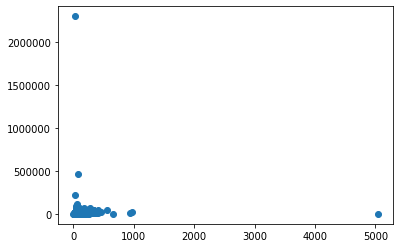

In [31]:
plt.scatter(data_raw['Area'], data_raw['Price'])
pass

Можно вот так:

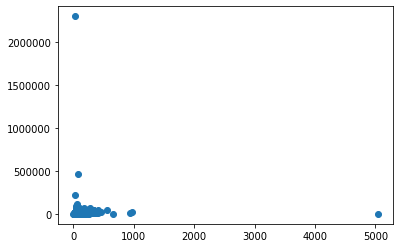

In [32]:
plt.scatter(x='Area', y='Price', data=data_raw)
pass

Мы видим, что основная масса точек сгрудилась в левом нижнем углу. Какие-то точки соответствуют квартирам с чрезмерно большими значениями цены или площади. Например, более $2$ млрд. руб. или $5$ тыс. Это *выбросы* (*outliers*) - объекты, значения признаков которых сильно отличаются от признаков основной массы объектов, сильно выпадающих из общей картины. Возможно, это ошибки в данных. В любом случае выбросы, как правило, мешают построить хорошее решающее правило и их рекомендуется выбрасывать.

Для обнаружения выбросов найдем, например, квантили для признаков `Price` и `Area`:

In [33]:
data_raw['Price'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      800.0
0.010     1000.0
0.050     1500.0
0.100     1700.0
0.500     2850.0
0.900     5500.0
0.950     7000.0
0.990    12000.0
0.995    14900.0
Name: Price, dtype: float64

Мы видим, например, что $99.9\%$ всех значений признака `'Price'` находится в диапазоне от $800$ до $14900$ тыс. руб. (это значения квантилей, соответствующих уровням $0.005$ и $0.995$ соотвтетственно)

In [34]:
data_raw['Area'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     18.0
0.010     19.0
0.050     29.0
0.100     31.0
0.500     46.0
0.900     80.0
0.950     94.0
0.990    150.0
0.995    162.0
Name: Area, dtype: float64

$99.9\%$ всех значений `'Area'` находится в диапазоне от $18$ до $162$ тыс. руб. 

Удалим все строки таблицы, в которых `'Price'` или `'Area'` выходят за пределы квантилей $0.005$, $0.995$.

In [35]:
rows_to_drop = data_raw[
    (data_raw['Price'] < data_raw['Price'].quantile(0.005)) | (data_raw['Price'] > data_raw['Price'].quantile(0.995)) | 
    (data_raw['Area']  < data_raw['Area' ].quantile(0.005)) | (data_raw['Area']  > data_raw['Area' ].quantile(0.995))].index
data = data_raw.drop(rows_to_drop)
data.shape

(71265, 10)

In [36]:
rows_to_drop

Int64Index([    6,    34,    41,   215,   222,   274,   338,   366,   418,
              471,
            ...
            71441, 71551, 71759, 71932, 71993, 72018, 72109, 72128, 72269,
            72311],
           dtype='int64', length=1114)

## 3. Визуализация и описательная статистика

Визуализация и описательная статистика - важные этапы анализа данных.
Сводную информацию о признаках можем получить, вызвав метод `describe`:

In [37]:
data.describe()

,Price,Date,Lat,Lng,Floors,Rooms,Floor,Area
count,71265.000000,71265.000000,71265.000000,71265.000000,71248.000000,71248.000000,71248.000000,71248.000000
mean,3310.907396,264.311120,56.295105,43.935371,9.406425,1.945977,5.188525,52.503329
std,1748.493102,87.897571,0.044836,0.081757,5.131401,0.910165,3.876806,21.402428
min,800.000000,56.000000,54.862751,41.806470,1.000000,0.000000,1.000000,18.000000
25%,2200.000000,190.000000,56.265022,43.868571,5.000000,1.000000,2.000000,37.000000
50%,2850.000000,295.000000,56.300147,43.931804,9.000000,2.000000,4.000000,46.000000
75%,3850.000000,344.000000,56.325320,44.005985,12.000000,3.000000,7.000000,63.000000
max,14900.000000,372.000000,57.127867,44.485489,25.000000,6.000000,25.000000,162.000000


Для каждого количественного признака приведены средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей.

По умолчанию этот метод дает информацию только о количественных признаках.
Получил информацию о категориальных:

In [38]:
data.describe(include=['category'])

,Type,Building
count,71248,71248
unique,2,5
top,Resale,Brick
freq,63136,52408


Давайте снова построим диаграмму рассеивания для признаков `'Area'`, `'Price'`:

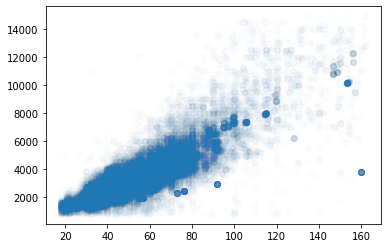

In [39]:
plt.scatter(data['Area'], data['Price'], alpha=0.01)
pass

Точки выстроились более-менее вдоль прямой идущей из нижнего левого угла в правый верхний: т.е. в некотором приближении зависимость стоимости квартиры от ее площади линейная.

Отрисовка всех точек требует много времени. Тем более, точки накладываются друг на друга и сложно понять сколько точек на том или ином участке графика (особенно, если не использовать параметр `alpha`). Поэтому изобразим только $1000$ случайных точек:

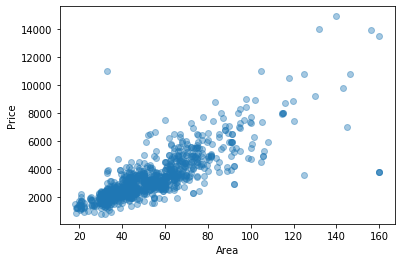

In [40]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
plt.scatter(data.iloc[random_subset]['Area'], data.iloc[random_subset]['Price'], alpha=0.4)
plt.xlabel('Area')
plt.ylabel('Price')
pass

Построим диаграмму рассеивания для признаков `'Price'` и `'Date'`:

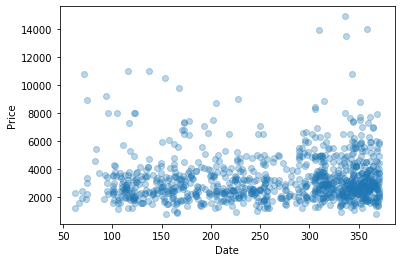

In [41]:
plt.scatter(data.iloc[random_subset]['Date'], data.iloc[random_subset]['Price'], alpha = .3)
plt.xlabel('Date')
plt.ylabel('Price')
pass

Из рисунка понятно, что, по-видимому, никакой зависимости между ценой и датой нет.
Однако видно, что точки сгущаются с ростом значения `Date`, т.е. продажи увеличиваются.

Для отрисовки диаграммы рассеивания мы можем воспользоваться более продвинутой функцией `scatterplot` из модуля `seaborn`. Например, в следующей диаграмме цвет маркеров соответствует типу строения `'Building'`, а размер - количеству комнат `'Rooms'`:

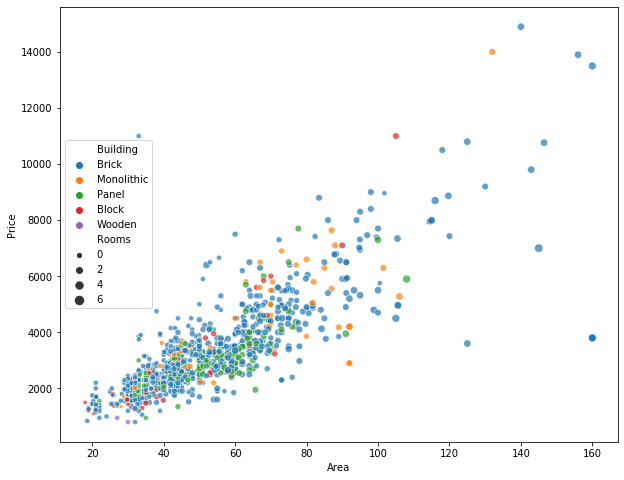

In [42]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='Area', y='Price', size='Rooms', hue='Building', data=data.iloc[random_subset], alpha=0.7)
pass

Мы видим, что наблюдается ожидаемая корреляция между количеством комнат и площадью квартиры. Также можно увидеть, что квартиры в панельных домах, как правило, имеют умеренные размеры и умеренные цены. Квартиры в монолитных домах, как правило, больше и дороже. Кирпичные дома бываю в разной ценовой категории, но самые большие и дорогие квартиры - в основном в кирпичных домах.

Построим все возможные диаграммы рассеивания для каждой пары переменных:

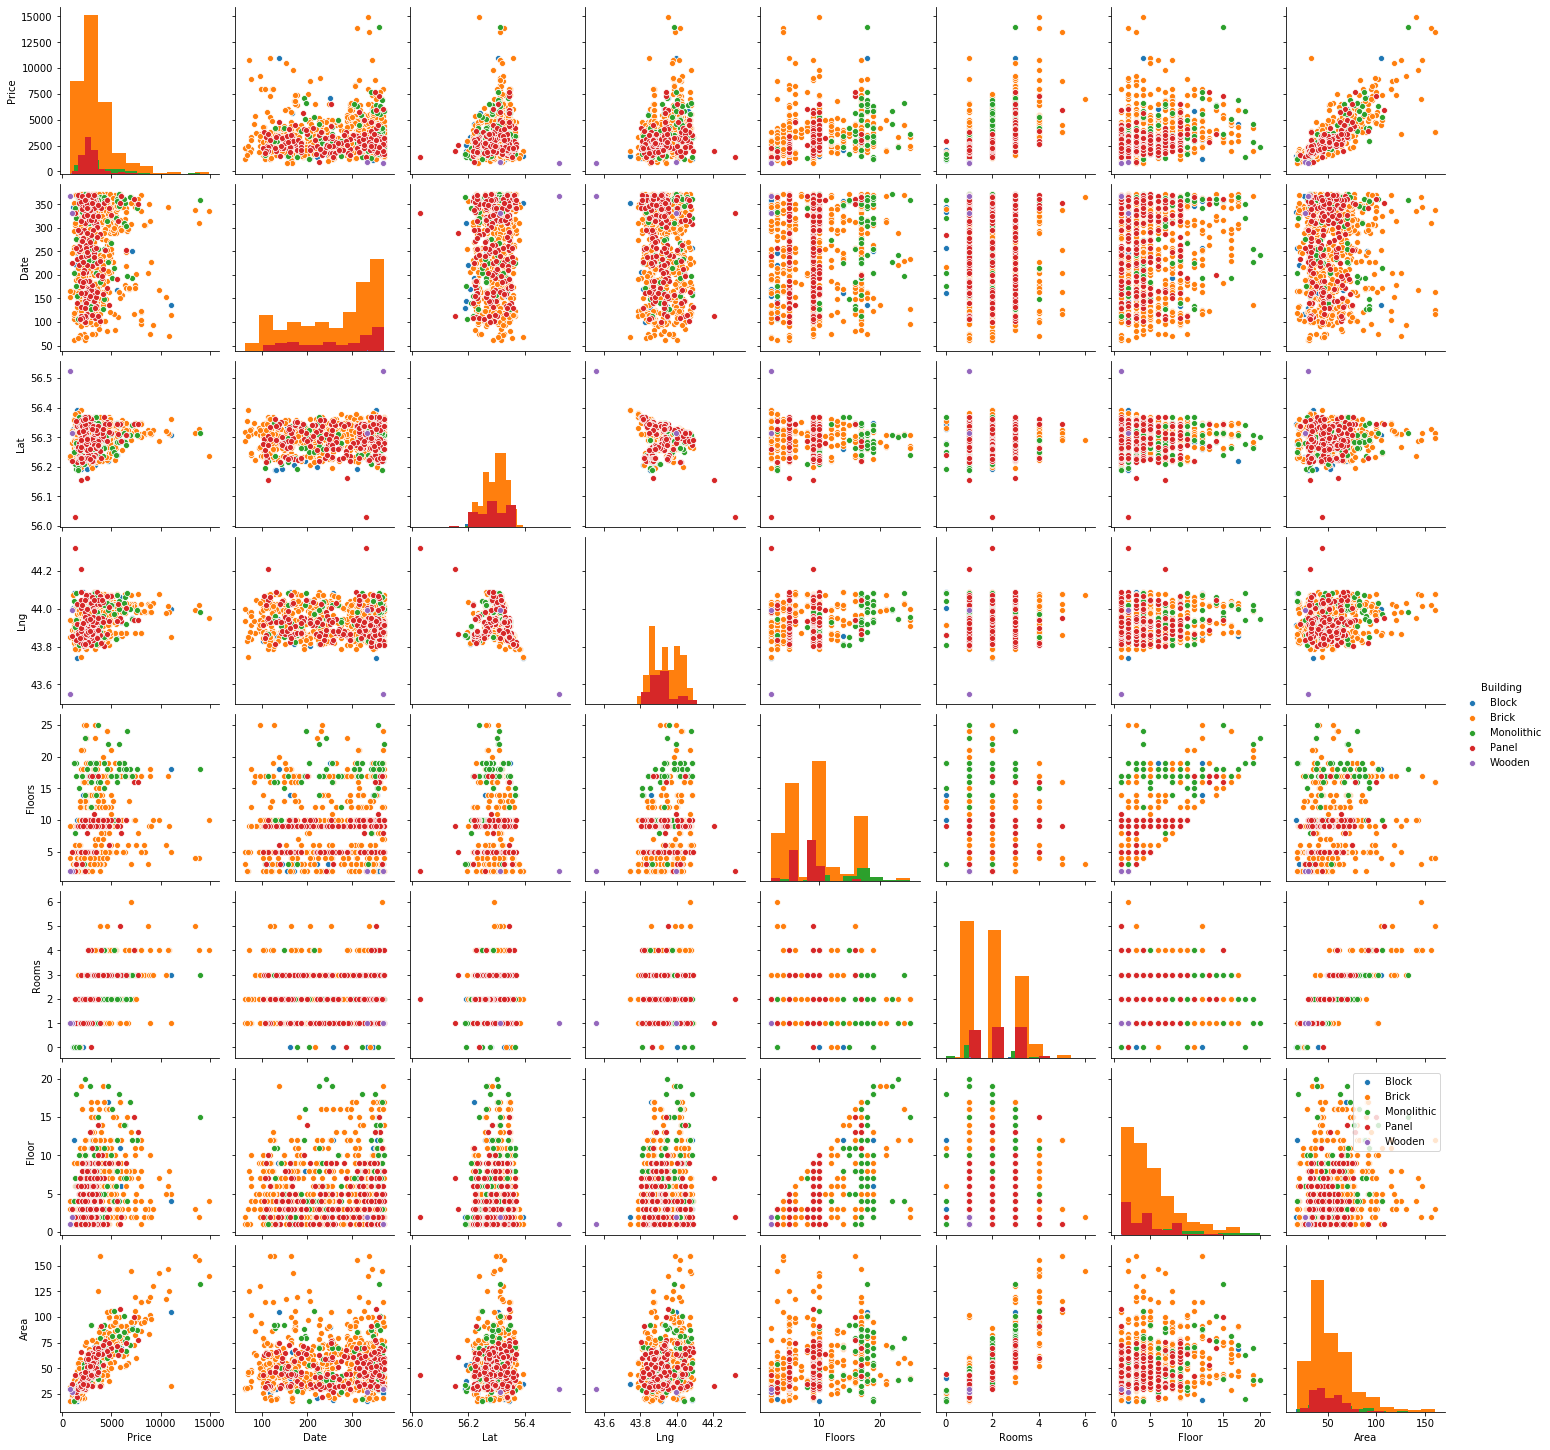

In [43]:
sns.pairplot(data.iloc[random_subset], hue='Building', diag_kind='hist')
plt.legend()
pass

На диаграммах, в частности, наблюдается попарная корреляция между `Price`, `Area` и `Rooms`.

На диагонали расположены гистограммы распределения признаков. Гистограммы можно построить отдельно.

Построить гистограмму можно с помощю функции `plt.hist`, но мы воспользуемся `distplot` из библиотеки `seaborn`.

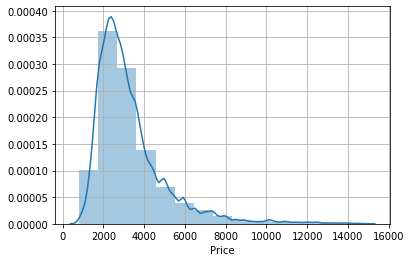

In [44]:
sns.distplot(data['Price'], bins=15)
plt.grid()
pass

Можно представить вместе и диаграмму рассеивания для пары признаков и соответствующие гистограммы:

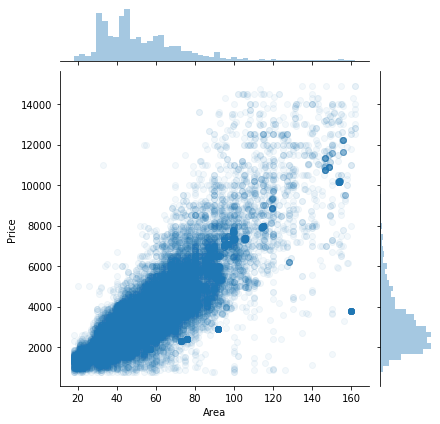

In [45]:
sns.jointplot(x='Area', y='Price', alpha=.05, data=data)
pass

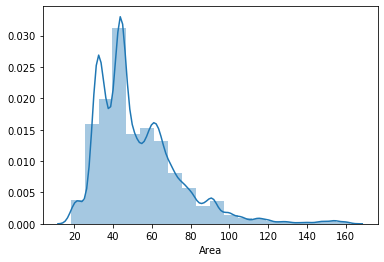

In [46]:
sns.distplot(data['Area'], bins = 20)
pass

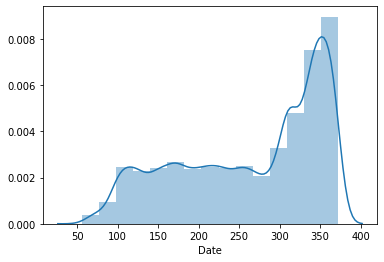

In [47]:
sns.distplot(data['Date'], bins = 15)
pass

*Ящик с усами* (*бокс-диаграмма*) - это один из возможных способов визуального представления распределения. Нижний и верхний концы ящика соответствуют 1-му и 3-му квартилям (25% и 75% квантилям соответственно), а горизонтальная линия внутри ящика - медиане. Верхний ус продолжается вверх вплоть до максимального значения, но не выше 1.5 межквартильного расстояния от верхней кромки ящика. Аналогично нижний ус - продолжается вниз до минимального значения, но не ниже 1.5 межквартильных расстояний от нижней кромки ящика. На концах усов ставятся небольшие зарубки. За пределами усов значения изображаются в виде отдельных точек - эти значения можно считать выбросами.

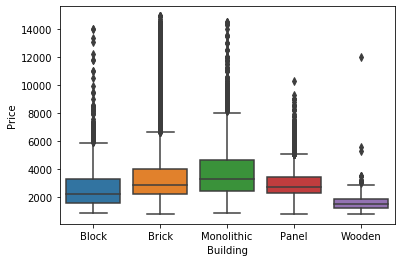

In [48]:
sns.boxplot(x="Building", y="Price", data=data)
pass

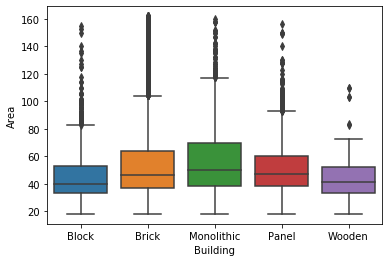

In [49]:
sns.boxplot(x="Building", y="Area", data=data)
pass

Также информацию о характере распределения можно получить из *скрипичных графиков* (violin plots). В этом случае изображают графики аппроксимации плотности вероятности.

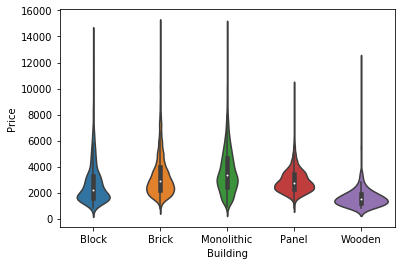

In [50]:
sns.violinplot(x="Building", y="Price", data=data)
pass

Можно вычислить матрицу корреляции для количественных признаков:

In [51]:
corr_mat = data.corr()
corr_mat

,Price,Date,Lat,Lng,Floors,Rooms,Floor,Area
Price,1.000000,0.033228,0.174728,0.305763,0.359210,0.554399,0.252512,0.852936
Date,0.033228,1.000000,0.010290,-0.002029,0.045034,-0.002045,0.032884,0.013564
Lat,0.174728,0.010290,1.000000,0.017505,0.079252,0.101350,0.048735,0.154772
Lng,0.305763,-0.002029,0.017505,1.000000,0.221267,0.026272,0.150245,0.177080
Floors,0.359210,0.045034,0.079252,0.221267,1.000000,-0.048981,0.641791,0.266499
Rooms,0.554399,-0.002045,0.101350,0.026272,-0.048981,1.000000,-0.022297,0.776492
Floor,0.252512,0.032884,0.048735,0.150245,0.641791,-0.022297,1.000000,0.182830
Area,0.852936,0.013564,0.154772,0.177080,0.266499,0.776492,0.182830,1.000000


Удобно использовать визуальный образ этой матрицы. Чем светлее ячейка, тем больше по абсолютной величине коэффициент корреляции:

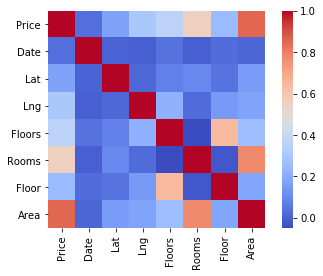

In [52]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Выведем коэффициенты корреляции, большие заданного значения:

In [53]:
corr_mat > 0.5

,Price,Date,Lat,Lng,Floors,Rooms,Floor,Area
Price,True,False,False,False,False,True,False,True
Date,False,True,False,False,False,False,False,False
Lat,False,False,True,False,False,False,False,False
Lng,False,False,False,True,False,False,False,False
Floors,False,False,False,False,True,False,True,False
Rooms,True,False,False,False,False,True,False,True
Floor,False,False,False,False,True,False,True,False
Area,True,False,False,False,False,True,False,True


In [54]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

Price   Area     0.852936
Rooms   Area     0.776492
Floors  Floor    0.641791
Price   Rooms    0.554399
dtype: float64

Достаточно большие значения этих коэффициентов вполне объяснимы.

Обратите внимание на небольшую корреляцию между ценой квартиры и географическими координатами (квартиры в нагорной части и особенно в нижегородском районе - дороже):

In [55]:
corr_mat.loc['Price', 'Lng'], corr_mat.loc['Price', 'Lat']

(0.3057627080568723, 0.17472831974270644)

Также обратите внимание, что коэффициент корреляции между `'Price'`, `'Date'` практически равен нулю

In [56]:
corr_mat.loc['Price', 'Date']

0.0332282805637181

Например, выберем все данные, соответствующие квартирам в деревянных строениях ценой больше 3 млн. и выше:

In [57]:
data.loc[(data['Building']=='Wooden') & (data['Price'] >= 3000), :]

,Price,Date,Lat,Lng,Type,Floors,Building,Rooms,Floor,Area
5396,5300.0,354,56.321805,44.004172,Resale,2.0,Wooden,5.0,2.0,103.0
7645,3500.0,221,56.205918,43.799766,Resale,2.0,Wooden,2.0,1.0,110.0
8548,3120.0,145,56.313518,44.008223,Resale,2.0,Wooden,3.0,1.0,70.0
12762,3100.0,310,56.323503,44.024052,Resale,2.0,Wooden,3.0,1.0,72.0
20220,3000.0,365,56.326333,44.021428,Resale,2.0,Wooden,2.0,1.0,53.0
23092,3200.0,181,56.266806,44.061916,Resale,3.0,Wooden,1.0,2.0,83.0
41743,5600.0,342,56.315061,43.988227,Resale,2.0,Wooden,4.0,2.0,103.0
47589,3200.0,316,56.312075,44.039224,Resale,1.0,Wooden,2.0,1.0,52.0
54033,3500.0,312,56.323343,44.019398,Resale,2.0,Wooden,2.0,1.0,47.0
58941,3500.0,369,56.306727,43.992027,Resale,1.0,Wooden,2.0,1.0,40.0


Или все данные, соответствующие продажам в деревянных новостройках:

In [58]:
data.loc[(data['Building']=='Wooden') & (data['Type']=='New'), :]

,Price,Date,Lat,Lng,Type,Floors,Building,Rooms,Floor,Area


Значения, которые принимают категориальные признаки, можно получить следующим образом:

In [59]:
data['Type'].unique()

[Resale, New, NaN]
Categories (2, object): [Resale, New]

In [60]:
data['Building'].unique()

[Brick, Panel, Block, Monolithic, Wooden, NaN]
Categories (5, object): [Brick, Panel, Block, Monolithic, Wooden]

Обратите внимание, что в столбце `'Building'` имеются пропущенные значения (закодированные значением `np.nan`).

Интересно посмотреть, сколько раз номинальные переменные принимают то или иное значение

In [61]:
data['Type'].value_counts() 

Resale    63136
New        8112
Name: Type, dtype: int64

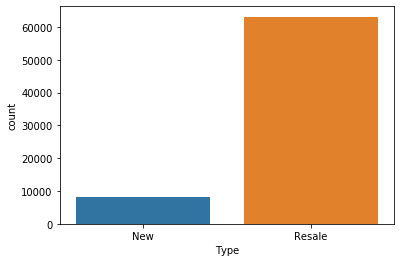

In [62]:
sns.countplot(x='Type', data=data)
pass

In [63]:
data['Building'].value_counts() 

Brick         52408
Panel         12170
Monolithic     4482
Block          1911
Wooden          277
Name: Building, dtype: int64

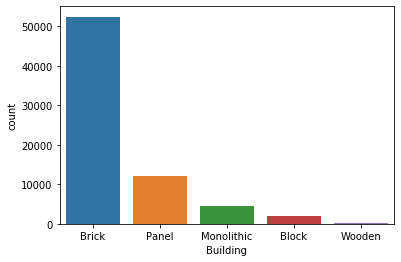

In [64]:
sns.countplot(x='Building', order=data['Building'].value_counts().index, data=data)
pass

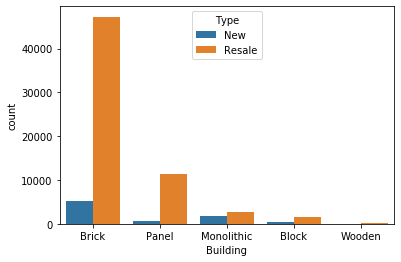

In [65]:
sns.countplot(x='Building', order=data['Building'].value_counts().index, hue='Type', data=data)
pass

##  4. Заполнение пропущенных значений 

Пропущенные значения в таблице представлены значениями `np.nan`. 
Посмотрим, сколько пропущенных значений в каждом столбце матрицы:

In [66]:
data.isna().sum()  

Price        0
Date         0
Lat          0
Lng          0
Type        17
Floors      17
Building    17
Rooms       17
Floor       17
Area        17
dtype: int64

С пропущенными значениями надо что-то сделать. Например, можно просто удалить строки с пропущенными значениями. В нашем случае это разумно, так как таких строк немного. В некоторых случаях можно удалить столбцы с пропущенными значениями. Однако если данных мало такие простые стратегии могут привести к тому, что данных станет вообще ничтожное количество.

Простая разумная стратегия - заполнить пропущенные значения средним или медианой (для количественных признаков) или модой (для номинальных признаков).

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам:

In [67]:
data.fillna(data.median(axis = 0), axis=0 , inplace=True)

In [68]:
data.isna().sum()  

Price        0
Date         0
Lat          0
Lng          0
Type        17
Floors       0
Building    17
Rooms        0
Floor        0
Area         0
dtype: int64

Пропущенные значения в столбцах, соответствующих категориальным признакам, заполним модой:
    

In [69]:
data['Building'].fillna(data['Building'].mode().iloc[0], inplace=True)
data['Type'    ].fillna(data['Type'    ].mode().iloc[0], inplace=True)

In [70]:
data.isna().sum()  

Price       0
Date        0
Lat         0
Lng         0
Type        0
Floors      0
Building    0
Rooms       0
Floor       0
Area        0
dtype: int64

In [71]:
data.describe()

,Price,Date,Lat,Lng,Floors,Rooms,Floor,Area
count,71265.000000,71265.000000,71265.000000,71265.000000,71265.000000,71265.000000,71265.000000,71265.000000
mean,3310.907396,264.311120,56.295105,43.935371,9.406328,1.945990,5.188241,52.501778
std,1748.493102,87.897571,0.044836,0.081757,5.130792,0.910057,3.876387,21.400111
min,800.000000,56.000000,54.862751,41.806470,1.000000,0.000000,1.000000,18.000000
25%,2200.000000,190.000000,56.265022,43.868571,5.000000,1.000000,2.000000,37.000000
50%,2850.000000,295.000000,56.300147,43.931804,9.000000,2.000000,4.000000,46.000000
75%,3850.000000,344.000000,56.325320,44.005985,12.000000,3.000000,7.000000,63.000000
max,14900.000000,372.000000,57.127867,44.485489,25.000000,6.000000,25.000000,162.000000


In [72]:
data.describe(include=['category'])

,Type,Building
count,71265,71265
unique,2,5
top,Resale,Brick
freq,63153,52425


## 5. Бинаризация номинальных признаков

Алгоритмы из библиотеки scikit-learn (почти) не умеют работать напрямую с категориальными признаками. Поэтому их вначале надо закодировать с помощью числовых принаков.

Бинарный признак `'Type'` заменим на числовой. 

`'Resale'` → 0, `'New'`→ 1 

Сделать это можно так:

In [73]:
data['Type'] = pd.factorize(data['Type'])[0]

Альтернативный способ:

In [74]:
# data['Type'] = data['Type'].cat.codes

К категориальному (небинарному) признаку `'Building'` применим метод *бинаризации* (*one-hot encoding*), 
который заключается в следующем.

Этот признак принимает 5 значений: `'Block'`, `'Brick'`, `'Monolithic'`, `'Panel'`, `'Wooden'`.

Вместо признака `'Building'` будем использовать 5 новых признаков (dummy-признаков, dummy - фиктивный), которые так и назовем `'Block'`, `'Brick'`, `'Monolithic'`, `'Panel'`, `'Wooden'`. При этом 
- если признак `'Building'` принимает значение `'Block'`, то признак `'Block'` равен 1, а все остальные 0;
- если признак `'Building'` принимает значение `'Brick'`, то признак `'Brick'` равен 1, а все остальные 0
- и т.д.

Такую бинаризацию можно выполнить с помощью функции `get_dummies`:

In [75]:
Building_dummies = pd.get_dummies(data['Building'])

In [76]:
Building_dummies.head()

,Block,Brick,Monolithic,Panel,Wooden
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


Добавим эти dummy-столбцы к таблице и удалим столбец `Building`:

In [77]:
data = pd.concat((data, Building_dummies), axis=1)
data = data.drop(['Building'], axis=1)

In [78]:
data.head()

,Price,Date,Lat,Lng,Type,Floors,Rooms,Floor,Area,Block,Brick,Monolithic,Panel,Wooden
0,3500.0,240,56.365696,43.820250,0,9.0,3.0,4.0,60.0,0,1,0,0,0
1,4000.0,240,56.323057,44.007862,0,3.0,3.0,3.0,57.0,0,1,0,0,0
2,2150.0,240,56.267552,43.892107,0,5.0,2.0,1.0,38.0,0,0,0,1,0
3,3100.0,240,56.359963,43.813756,0,5.0,4.0,2.0,59.0,0,0,0,1,0
4,3585.0,240,56.325374,43.937463,0,9.0,2.0,7.0,52.5,0,0,0,1,0


## 6. Нормализация количественных признаков

Перед применением алгоритмов машинного обучения количественные признаки полезно нормализовать.

Наиболее часто используют один из двух следующих способов:
- *приведение к отрезку $[0,1]$* - это линейное преобразование, приводящее все значения к заданному отрезку;
- *стандартизация* - линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению.

Выполним стандартизацию всех признаков:

In [79]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)

In [80]:
data_stand.describe()

,Price,Date,Lat,Lng,Type,Floors,Rooms,Floor,Area,Block,Brick,Monolithic,Panel,Wooden
count,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04,7.126500e+04
mean,-3.457784e-14,3.415814e-14,1.189763e-10,1.461346e-11,-7.783650e-15,1.042658e-15,-2.840891e-17,1.679265e-15,4.902486e-14,2.609938e-15,7.636375e-15,-4.229541e-15,-1.124466e-14,-1.911193e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.436041e+00,-2.369930e+00,-3.194676e+01,-2.603922e+01,-3.583966e-01,-1.638407e+00,-2.138317e+00,-1.080450e+00,-1.612224e+00,-1.659937e-01,-1.668114e+00,-2.590597e-01,-4.538025e-01,-6.246610e-02
25%,-6.353513e-01,-8.454286e-01,-6.709721e-01,-8.170459e-01,-3.583966e-01,-8.588008e-01,-1.039485e+00,-8.224775e-01,-7.243784e-01,-1.659937e-01,-1.668114e+00,-2.590597e-01,-4.538025e-01,-6.246610e-02
50%,-2.636026e-01,3.491437e-01,1.124355e-01,-4.362416e-02,-3.583966e-01,-7.919410e-02,5.934758e-02,-3.065331e-01,-3.038198e-01,-1.659937e-01,5.994710e-01,-2.590597e-01,-4.538025e-01,-6.246610e-02
75%,3.083184e-01,9.066107e-01,6.738943e-01,8.637058e-01,-3.583966e-01,5.055109e-01,1.158180e+00,4.673834e-01,4.905686e-01,-1.659937e-01,5.994710e-01,-2.590597e-01,-4.538025e-01,-6.246610e-02
max,6.628046e+00,1.225163e+00,1.857363e+01,6.728663e+00,2.790166e+00,3.039233e+00,4.454676e+00,5.110882e+00,5.116713e+00,6.024241e+00,5.994710e-01,3.860059e+00,2.203571e+00,1.600846e+01


## 7. Отбор признаков 

Для предсказания цены квартиры будем использовать все входные признаки, кроме `Date`.

In [81]:
data_stand.columns

Index(['Price', 'Date', 'Lat', 'Lng', 'Type', 'Floors', 'Rooms', 'Floor',
       'Area', 'Block', 'Brick', 'Monolithic', 'Panel', 'Wooden'],
      dtype='object')

In [82]:
X = data_stand.drop(['Price', 'Date'], axis=1)
y = data['Price']

Можно конвертировать таблицы в массивы:

In [83]:
#X = np.array(data_stand.drop(['Price', 'Date'], axis=1))
#y = np.array(data['Price'])

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(53448, 17817)

## 8. Линейная регрессия 

- Создаем модель и задаем гиперпараметры (конструктор)
- Тренируем модель (метод `fit`)
- Используем модель на новых данных (метод `predict`) и измеряем качество модели

In [85]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
y_train_predict = lr_model.predict(X_train)
y_test_predict  = lr_model.predict(X_test)

In [87]:
lr_model.coef_

array([ 6.02006117e+01,  2.19592321e+02, -3.95453470e+01,  1.05169881e+02,
       -3.41135703e+02,  3.12635159e+01,  1.67635576e+03, -1.05285283e+15,
       -2.87416196e+15, -1.58223307e+15, -2.45257460e+15, -4.05540211e+14])

### Измеряем метрики качества

*Остаточная сумма квадратов*:
$$
{\rm RSS} = \sum_{i=1}^N \left(y^{(i)} - \widehat{y}^{(i)} \right)^2
$$
где 
$$
\widehat{y}^{(i)} = \beta_0 + \sum_{j=1}^d \beta_j x_j^{(i)}
$$

*Полная сумма квадратов*:
$$
{\rm TSS} = \sum_{i=1}^N \left(y^{(i)} - \overline{y} \right)^2,
$$
где 
$$
\overline{y} = \frac{1}{N} \sum_{i=1}^N y^{(i)}
$$

$$
\overline{y} = \beta_0 + \sum_{j=1}^d \beta_j \overline{x}_j
$$


*Сумма квадратов, обусловленная регрессией*:
$$
{\rm ESS} = \sum_{i=1}^N \left(\overline{y} - \widehat{y}^{(i)} \right)^2
$$

Можно показать, что
$$
{\rm TSS} = {\rm RSS} + {\rm ESS}
$$

*Коэффициент детерминации*, или *коэффициент регрессии Пирсона*:
$$
R^2 = 1 - \frac{{\rm RSS}}{{\rm TSS}} = \frac{{\rm ESS}}{{\rm TSS}}
$$
— доля объясняемого регрессией разброса относительно среднего (чем ближе к 1, тем модель лучше объясняет данные).

$$
0 \le R^2 \le 1
$$

$R = \sqrt{R^2}$ равно (по модулю) выборочной корреляции между $y^{(i)}$ и $\widehat{y}^{(i)}$

Если $d = 1$, то $R$ равен (по модулю) выборочной корреляции между $y^{(i)}$ и $x^{(i)}$.

*Средняя сумма квадратов отклонений* (MSE - Mean Squared Error)
$$
{\rm MSE} = \frac{1}{N} {\rm RSS} = \frac{1}{N} \sum_{i=1}^N \left(y^{(i)} - \widehat{y}^{(i)} \right)^2
$$

*Среднеквадратическая ошибка* (RMSE - Rooted Mean Squared Error)
$$
{\rm RMSE} = \sqrt{{\rm MSE}}
$$

MSE иногда называют *средней квадратической ошибкой*, что, конечно же, правильней отражает суть дела, но добавляет путаницы.

Для вычисления этих метрик можно воспользоваться соответствующими функциями из модуля `metrics` библиотеки `sklearn`, но можно также вычислить "вручную". Значение $R^2$ также вычисляет метод `score` объекта `LinearRegression`

In [88]:
from sklearn.metrics import mean_squared_error, r2_score

MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)

MSE_train, MSE_test, R2_train, R2_test

(680391.8336842395, 646837.8801769295, 0.7785898643883027, 0.7850726934253254)

In [89]:
lr_model.score(X_train, y_train) # Коэффициент детерминации R^2

0.7785898643883027

In [90]:
lr_model.score(X_test, y_test)

0.7850726934253254

In [91]:
MSE_train = np.mean((y_train_predict - y_train)**2)
MSE_test  = np.mean((y_test_predict - y_test)**2)
MSE_train, MSE_test

(680391.8336842455, 646837.8801769273)

In [92]:
np.sqrt(MSE_train), np.sqrt(MSE_test)

(824.8586749766565, 804.2623205005488)

### Как цена зависит от площади квартиры?

Попробуем построить линейную модель, описывающую зависимость `Price` только от `Area`

In [93]:
lr_model = LinearRegression()
lr_model.fit(X_train[['Area']], y_train)

y_train_predict = lr_model.predict(X_train[['Area']])
y_test_predict  = lr_model.predict(X_test[['Area']])

In [94]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)

In [95]:
np.sqrt(MSE_train), np.sqrt(MSE_test)

(917.3718123137436, 899.3036150457865)

### Как цена зависит от количества комнат?

Попробуем построить линейную модель, описывающую зависимость `Price` только от `Rooms`

In [96]:
lr_model = LinearRegression()
lr_model.fit(X_train[['Rooms']], y_train)

y_train_predict = lr_model.predict(X_train[['Rooms']])
y_test_predict  = lr_model.predict(X_test[['Rooms']])

In [97]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)

In [98]:
np.sqrt(MSE_train), np.sqrt(MSE_test)

(1458.981115973685, 1443.8483136229686)

Ошибка заметно возрасла

### Как цена зависит от площади и количества комнат?

Попробуем построить линейную модель, описывающую зависимость `Price` от `Area` и `Rooms`

In [99]:
lr_model = LinearRegression()
lr_model.fit(X_train[['Area', 'Rooms']], y_train)

y_train_predict = lr_model.predict(X_train[['Area', 'Rooms']])
y_test_predict  = lr_model.predict(X_test[['Area', 'Rooms']])

In [100]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)

In [101]:
np.sqrt(MSE_train), np.sqrt(MSE_test)

(866.9660247204029, 848.6218659646153)

## 9. Случайный лес (Random Forest)

In [102]:
from sklearn import ensemble
rf_model = ensemble.RandomForestRegressor(n_estimators = 100)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [103]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)

In [104]:
np.sqrt(MSE_train), np.sqrt(MSE_test)

(866.9660247204029, 848.6218659646153)

Полученные ошибки больше, чем ошибки линейной регрессии (при использовании всех признаков)

Метод Random Forest позволяет получить некоторые оценки "*важности*" признаков.
Чем значение больше, тем признак важнее.

In [105]:
importances = rf_model.feature_importances_
importances

array([6.22139845e-02, 7.34654792e-02, 2.99875976e-03, 5.59412566e-02,
       1.12561695e-02, 1.67005144e-02, 7.72393908e-01, 3.33813648e-04,
       1.30097657e-03, 1.85886292e-03, 1.41056163e-03, 1.25713024e-04])

In [106]:
np.sum(importances)

1.0

In [107]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

Area          0.772394
Lng           0.073465
Lat           0.062214
Floors        0.055941
Floor         0.016701
Rooms         0.011256
Type          0.002999
Monolithic    0.001859
Panel         0.001411
Brick         0.001301
Block         0.000334
Wooden        0.000126
dtype: float64

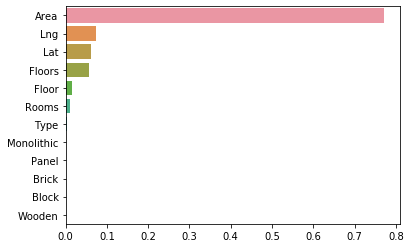

In [108]:
sns.barplot(y=importances.index, x=importances, orient="h")
pass